# Iterators

My favorite "feature" of pandas is that it's written in Python.
Python has great language-level features for handling streams of text
that don't nescessarily fit in memory.

In [5]:
%matplotlib inline

import os
import gzip
from itertools import islice, takewhile

import numpy as np
import pandas as pd
import seaborn as sns
import dask.dataframe as dd
from toolz import partition_all, partitionby
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10

In [3]:
HEADER = 512
with gzip.open("data/beeradvocate.tar.gz", "r") as f:
    f.seek(HEADER)
    print(f.read(1500).decode('utf-8'))

beer/name: Sausa Weizen
beer/beerId: 47986
beer/brewerId: 10325
beer/ABV: 5.00
beer/style: Hefeweizen
review/appearance: 2.5
review/aroma: 2
review/palate: 1.5
review/taste: 1.5
review/overall: 1.5
review/time: 1234817823
review/profileName: stcules
review/text: A lot of foam. But a lot.	In the smell some banana, and then lactic and tart. Not a good start.	Quite dark orange in color, with a lively carbonation (now visible, under the foam).	Again tending to lactic sourness.	Same for the taste. With some yeast and banana.		

beer/name: Red Moon
beer/beerId: 48213
beer/brewerId: 10325
beer/ABV: 6.20
beer/style: English Strong Ale
review/appearance: 3
review/aroma: 2.5
review/palate: 3
review/taste: 3
review/overall: 3
review/time: 1235915097
review/profileName: stcules
review/text: Dark red color, light beige foam, average.	In the smell malt and caramel, not really light.	Again malt and caramel in the taste, not bad in the end.	Maybe a note of honey in teh back, and a light fruitiness.	Av

This is a dataset on beer reviews from beeradvocate.com.
It's a plaintext file where

- Reviews are separated by blank lines (i.e. the line is just `'\n'`)
- Each field of a review is its own line formated like `meta/field: value`

Pandas can't read this file natively, but we have Python!

## Developing a solution

In [11]:
f = gzip.open("data/beeradvocate.tar.gz", "rt")
f.seek(0)
f.seek(HEADER)

512

We can't just read in the entire file into memory.
Let's grab the first review using takewhile.

In [12]:
from itertools import takewhile

In [13]:
first = list(takewhile(lambda x: x != '\n', f))
first

['beer/name: Sausa Weizen\n',
 'beer/beerId: 47986\n',
 'beer/brewerId: 10325\n',
 'beer/ABV: 5.00\n',
 'beer/style: Hefeweizen\n',
 'review/appearance: 2.5\n',
 'review/aroma: 2\n',
 'review/palate: 1.5\n',
 'review/taste: 1.5\n',
 'review/overall: 1.5\n',
 'review/time: 1234817823\n',
 'review/profileName: stcules\n',
 'review/text: A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t\n']

That's essentially a dictionary, but we need to split they keys and values, cleanup some line endings.

In [15]:
r = dict([x.strip('\n').split(": ", 1) for x in first])
r

{'beer/ABV': '5.00',
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'beer/name': 'Sausa Weizen',
 'beer/style': 'Hefeweizen',
 'review/appearance': '2.5',
 'review/aroma': '2',
 'review/overall': '1.5',
 'review/palate': '1.5',
 'review/profileName': 'stcules',
 'review/taste': '1.5',
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.\t\t',
 'review/time': '1234817823'}

Notice that optional argument to split; If a review had contained a literal `': '`, we'd be in trouble without limiting the split to just 1.

In [16]:
'review/text: Why I love beer: 1. '.split(': ')

['review/text', 'Why I love beer', '1. ']

Lets wrap that up into a function `format_review`

In [18]:
def format_review(review):
    return dict(map(lambda x: x.strip('\n').split(": ", 1), review))

Assuming we've processed many reviews into a list, we'll then build op a DataFrame.

In [23]:
pd.DataFrame([r])

,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/profileName,review/taste,review/text,review/time
0,5.00,47986,10325,Sausa Weizen,Hefeweizen,2.5,2,1.5,1.5,stcules,1.5,A lot of foam. But a lot.\tIn the smell some b...,1234817823


We have a bit of dtype work to do:

In [24]:
col_names = {
    'beer/ABV': 'abv',
    'beer/beerId': 'beer_id',
    'beer/brewerId': 'brewer_id',
    'beer/name': 'beer_name',
    'beer/style': 'beer_style',
    'review/appearance': 'review_appearance',
    'review/aroma': 'review_aroma',
    'review/overall': 'review_overall',
    'review/palate': 'review_palate',
    'review/profileName': 'profile_name',
    'review/taste': 'review_taste',
    'review/text': 'text',
    'review/time': 'time'
}
df = pd.DataFrame([r])
numeric = ['abv', 'review_appearance', 'review_aroma',
           'review_overall', 'review_palate', 'review_taste']
df = (df.rename(columns=col_names)
        .replace('', np.nan))
df[numeric] = df[numeric].astype(float)
df['time'] = pd.to_datetime(df.time.astype(int), unit='s')
df

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
0,5.0,47986,10325,Sausa Weizen,Hefeweizen,2.5,2.0,1.5,1.5,stcules,1.5,A lot of foam. But a lot.\tIn the smell some b...,2009-02-16 20:57:03


Writing that as a function:

In [25]:
def as_dataframe(reviews):
    col_names = {
        'beer/ABV': 'abv',
        'beer/beerId': 'beer_id',
        'beer/brewerId': 'brewer_id',
        'beer/name': 'beer_name',
        'beer/style': 'beer_style',
        'review/appearance': 'review_appearance',
        'review/aroma': 'review_aroma',
        'review/overall': 'review_overall',
        'review/palate': 'review_palate',
        'review/profileName': 'profile_name',
        'review/taste': 'review_taste',
        'review/text': 'text',
        'review/time': 'time'
    }
    df = pd.DataFrame(list(reviews))
    numeric = ['abv', 'review_appearance', 'review_aroma',
               'review_overall', 'review_palate', 'review_taste']
    df = (df.rename(columns=col_names)
            .replace('', np.nan))
    df[numeric] = df[numeric].astype(float)
    df['time'] = pd.to_datetime(df.time.astype(int), unit='s')
    return df

And now we can process the files; We'll get a handle for the full dataset, and stream chunks through our little pipeline of

1. split reviews on `'\n'`
2. pipe lines through `format_review`, returning a review
3. pipe lists of reviews through `as_dataframe`

```python
with gzip.open("data/beeradvocate.tar.gz", "rt") as f:
    f.seek(HEADER)
    lines = (x for x in f if not x.startswith('\x00'))
    review_lines = filter(lambda x: x != ('\n',),
                          partitionby(lambda x: x == '\n', lines))
    reviews = map(format_review, review_lines)
    chunks = partition_all(100000, reviews)

    dfs = (as_dataframe(chunk) for chunk in chunks)
    os.makedirs("data/beer/", exist_ok=True)

    for i, df in enumerate(dfs):
        df.to_csv("data/beer/chunk_%s.csv.gz" % i, index=False,
                  compression="gzip")
        print(i)
```

# Using Dask

The row order in the raw file seemed to be random. I wanted to grab
out an interesting subset: All reviews by the top 750 reviewers.

Again, we have the problem that the dataset doesn't quite fit in memory.
We could manually loop through the list of CSVs, keeping track of the count
of reviews per reviewer, manually freeing the memory after finishing that
CSV, but we'll let dask do it for us.

In [26]:
import dask.dataframe as dd

from dask.diagnostics import ResourceProfiler, ProgressBar
prof = ResourceProfiler()
pbar = ProgressBar()

In [28]:
# read in df, note that it's `dd.read_csv`
df = dd.read_csv("data/beer/chunk*.csv.gz", compression="gzip",
                 parse_dates=['time'], blocksize=None)
df

dd.DataFrame<from-de..., npartitions=16>

Haven't actually done anything yet; Just collected some metadata.

Now let's get the counts.

In [29]:
vc = df.profile_name.value_counts()

Well, we still haven't done anything; Need to actually call `.compute` to trigger that.

In [30]:
with pbar, prof:
    profiles = vc.compute().index[:750]

[########################################] | 100% Completed | 28.1s


In [31]:
prof.visualize();

In [32]:
with prof, pbar:
    sdf = df[df.profile_name.isin(profiles)].compute()

[########################################] | 100% Completed | 27.4s


In [33]:
len(sdf)

752610

```python
sdf.sort_values('time').head(100000).to_csv(
    "data/beer/subset.csv.gz", compression="gzip")
```

In [34]:
%xdel sdf

# Aside: Python & Parallelism

Python has a slightly complicated concurrency & parallelism story.
The first thing you'll hear is that, "Python has a GIL, so you should never use threads".

The GIL, or "Global Interpreter Lock", is a CPython implementation detail that makes you writing CPython itself easier. The general idea is that only one thread touching *python* objects can run at a time. [David Beazley](http://www.dabeaz.com/GIL/) is the person to listen to on this subject.
You can end up with the strange case where adding threads actually slows down the computation.

The usual answer among python programmers is to use MultiProcessing. Oversimplifying again, this essentailly starts a new python interpreter, serializes and copys all the objects in your runtime, and starts the task. Any results are serialized and sent back to the main processes. It's that serialization overhead that can be prohibitively costly for scientific python. We'd much prefer the shared-memory parallelism offered by threads.

Fortunately for us, a lot of the scientific stack is written in C or Fortran. Above, I noted that the GIL only applies to *python* objects. A library using compiled extensions *can* release the GIL. Anthing built on top of

- NumPy
- SciPy
- Numba (if requested)
- scikit-learn
- scikit-image
- pandas*
 
Will have be able to use threads just fine. The asterisk is there for pandas because not bit of C code releases the GIL. Thanks to Jeff Reback's work, (at the prompting of Matthew Rocklin, who has [written about this](http://matthewrocklin.com/blog/work/2015/03/10/PyData-GIL)). A rough list includes

- groupby
- nsmallest
- value_counts
- factorize (used in Groupby)
- Some datetime operations
- parts of read_csv

For the most part, you as a user don't have anything to worry about. Just use dask, and you'll get shared-memory parallelism for free.

In [35]:
df = pd.read_csv("data/beer/subset.csv.gz", compression="gzip", index_col=0,
                 parse_dates=['time'])
df.head()

,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
64529,5.3,93,33,Steel Rail Extra Pale Ale,American Pale Ale (APA),3.5,3.5,4.0,4.0,Todd,4.0,"Presentation: Pint size, on tap from the Easts...",1996-08-22 00:00:01
86219,17.5,111,35,Samuel Adams Triple Bock,American Strong Ale,3.0,4.0,4.0,4.5,Todd,4.5,Presentation: 8.45oz blue bottle with gold let...,1998-01-10 00:00:01
64057,5.0,97,144,Special Amber,Vienna Lager,4.0,4.0,4.5,4.0,BeerAdvocate,4.0,Presentation: It is so pleasing to obtain beer...,1998-01-13 00:00:01
17043,4.8,51,139,Tremont Ale,English Pale Ale,3.0,3.5,4.0,3.5,BeerAdvocate,4.0,Presentation: Bottle and six-pack carrier have...,1998-01-21 00:00:01
29308,NaN,306,138,Casey's Smooth Stout,Irish Dry Stout,3.0,3.0,1.0,1.0,BeerAdvocate,1.0,Presentation: 12oz. green bottle.\t\tAppearanc...,1998-01-22 00:00:01


# Aside: Namespaces

Pandas has been expanding its use of namespaces (or accessors) on `DataFrame` to group together related methods. This also limits the number of methods direclty attached to `DataFrame` itself, which can be overwhelming.

Currently, we have these namespaces:

- `.str`: defined on `Series` and `Index`es containing strings (object dtype)
- `.dt`: defined on `Series` with `datetime64[ns]` dtype
- `.cat`: defined on `Series` and `Indexes` with `category` dtype
- `.plot`: defined on `Series` and `DataFrames`

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Make a barplot of the count of reviews, with one bar per hour.

- Hint: Use the `.dt` namespace

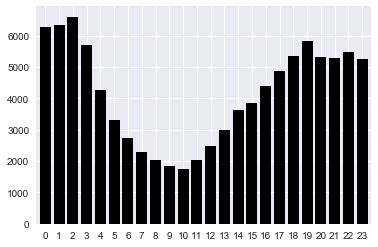

In [89]:
# %load solutions/groupby_03.py
# Make a barplot of review times by hour
(df.time.dt.hour
   .value_counts()
   .sort_index()
   .plot.bar(rot=0, color='k', width=.8));


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Make a variable `pas` that filters `df` to just rows containing `'pale ale'` (ignoring case)

In [91]:
# %load solutions/groupby_04.py
pas = df[df.beer_name.str.lower().str.contains("pale ale")]
pas.head()


,abv,beer_id,brewer_id,beer_name,beer_style,review_appearance,review_aroma,review_overall,review_palate,profile_name,review_taste,text,time
64529,5.3,93,33,Steel Rail Extra Pale Ale,American Pale Ale (APA),3.5,3.5,4.0,4.0,Todd,4.0,"Presentation: Pint size, on tap from the Easts...",1996-08-22 00:00:01
26093,6.8,147,45,Brooklyn East India Pale Ale,English India Pale Ale (IPA),3.0,4.0,3.0,3.0,BeerAdvocate,3.0,Presentation: The Brooklyn Brewery style logo ...,1998-02-14 00:00:01
27201,5.0,264,6994,Alexander Keith's India Pale Ale,English India Pale Ale (IPA),2.5,2.5,4.0,3.0,Todd,2.5,"Presentation: 12oz brown twisty, with a red st...",1998-04-16 00:00:01
29695,4.5,302,138,India Pale Ale,English India Pale Ale (IPA),3.5,3.5,3.5,3.0,BeerAdvocate,4.0,Presentation: 12oz. clear bottle (wide w/thin ...,1998-04-23 00:00:01
21013,5.4,186,141,Smuttynose Shoals Pale Ale,American Pale Ale (APA),3.0,3.5,4.0,4.0,BeerAdvocate,4.0,Presentation: 12 oz bottle with a picture of t...,1998-05-05 00:00:01


## Groupby

Comes up in a lot of contexts. At its root it's about doing an operation on many subsets of the data, each of which shares something in common. The general rule is

- Split: by a column name, array, function, mapping, etc
- Apply: You provide the function to apply to each group
- Combine: Pandas does this, but you provide a hint with `.agg` or `.transform` or `.apply`

In [66]:
gr = df.groupby("beer_name")
gr

In [67]:
review_cols = ['review_appearance', 'review_aroma', 'review_overall',
               'review_palate', 'review_taste']

In [68]:
# Average reviews
gr[review_cols].agg('mean').head()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
beer_name,,,,,
"""50"" Golden Anniversary Lager",5.000000,3.500000,4.000000,3.500000,3.50
"""Alt""ered State",4.000000,3.750000,3.500000,4.000000,4.00
"""Double Wrecked Wreck"" IPA",3.250000,3.750000,4.000000,4.000000,3.75
"""Marnie"" Gras Carnival Ale",3.666667,4.333333,3.833333,4.000000,4.00
"""Old Yeltsin"" Imperial Stout",4.166667,4.111111,3.666667,3.888889,4.00


In this case, the three parts were:

- Split: `beer_name`
- Apply: `'mean'`
- Combine: `agg => 1 row per group`

Let's start with `.agg` since it's the most common in my experience.

Many Combinations:

- Grouper: Controls the output index
  * single grouper -> Index
  * array-like grouper -> MultiIndex
- Subject (Groupee): Controls the output data values
  * single column -> Series (or DataFrame if multiple aggregations)
  * multiple columns -> DataFrame
- Aggregation: Controls the output columns
  * single aggfunc -> Index in the colums
  * multiple aggfuncs -> MultiIndex in the columns (Or 1-D Index if groupee is 1-D)

In [52]:
# single grouper, single groupee, single aggregation
df.groupby('beer_style').review_overall.agg('mean')

beer_style
Altbier                       3.841723
American Adjunct Lager        2.786441
American Amber / Red Ale      3.745512
American Amber / Red Lager    3.440703
American Barleywine           3.987275
                                ...   
Vienna Lager                  3.703660
Weizenbock                    4.040514
Wheatwine                     3.982353
Winter Warmer                 3.784073
Witbier                       3.875343
Name: review_overall, dtype: float64

In [53]:
# single grouper, single groupee, multiple aggregations
df.groupby('beer_style').review_overall.agg(['min', 'max'])

,min,max
beer_style,,
Altbier,1.0,5.0
American Adjunct Lager,1.0,5.0
American Amber / Red Ale,0.0,5.0
American Amber / Red Lager,1.0,5.0
American Barleywine,1.0,5.0
...,...,...
Vienna Lager,1.0,5.0
Weizenbock,1.5,5.0
Wheatwine,2.5,5.0


In [54]:
# single grouper, array-like groupee, single aggregations
df.groupby('beer_style')['review_overall', 'review_aroma'].agg('mean')

,review_overall,review_aroma
beer_style,,
Altbier,3.841723,3.633110
American Adjunct Lager,2.786441,2.394452
American Amber / Red Ale,3.745512,3.583622
American Amber / Red Lager,3.440703,3.165447
American Barleywine,3.987275,4.116077
...,...,...
Vienna Lager,3.703660,3.405549
Weizenbock,4.040514,4.067194
Wheatwine,3.982353,4.029412


In [55]:
# single grouper, array-like groupee, single multiple aggregations
df.groupby('beer_style')['review_overall', 'review_aroma'].agg(['mean', 'std'])

review_overall           review_aroma          
                                     mean       std         mean       std
beer_style                                                                
Altbier                          3.841723  0.689754     3.633110  0.576859
American Adjunct Lager           2.786441  0.888317     2.394452  0.711463
American Amber / Red Ale         3.745512  0.667070     3.583622  0.604162
American Amber / Red Lager       3.440703  0.813962     3.165447  0.690642
American Barleywine              3.987275  0.631467     4.116077  0.519372
...                                   ...       ...          ...       ...
Vienna Lager                     3.703660  0.684270     3.405549  0.594442
Weizenbock                       4.040514  0.596059     4.067194  0.529740
Wheatwine                        3.982353  0.502654     4.029412  0.483987
Winter Warmer                    3.784073  0.635730     3.812667  0.564829
Witbier                          3.875343  0.706408     3.741076  0.602042

[103 rows x 4 columns]

In [56]:
# multiple groupers, single groupee, single aggregation
df.groupby(['brewer_id', 'beer_name']).review_overall.mean()

brewer_id  beer_name                 
1          Eisbrau Czech                 3.250000
           Gambrinus                     4.250000
           Gambrinus Pale                3.250000
           Pilsner Urquell               3.673077
           Primus                        3.500000
                                           ...   
24926      Mongozo (Banana)              3.666667
           Mongozo (Palmnut)             3.630435
24964      Haffenreffer Private Stock    3.500000
26715      Gageleer                      3.500000
27039      Heady Topper                  4.300000
Name: review_overall, dtype: float64

In [57]:
# multiple groupers, single groupee, multiple aggregation
df.groupby(['brewer_id', 'beer_name']).review_overall.agg(['mean', 'count'])

mean  count
brewer_id beer_name                                  
1         Eisbrau Czech               3.250000      2
          Gambrinus                   4.250000      2
          Gambrinus Pale              3.250000      2
          Pilsner Urquell             3.673077    104
          Primus                      3.500000      1
...                                        ...    ...
24926     Mongozo (Banana)            3.666667      6
          Mongozo (Palmnut)           3.630435     23
24964     Haffenreffer Private Stock  3.500000      9
26715     Gageleer                    3.500000      1
27039     Heady Topper                4.300000      5

[15182 rows x 2 columns]

In [58]:
# multiple groupers, multiple groupee, single aggregation
df.groupby(['brewer_id', 'beer_name'])[review_cols].agg('mean')

review_appearance  review_aroma  \
brewer_id beer_name                                                     
1         Eisbrau Czech                        3.250000      3.000000   
          Gambrinus                            4.000000      4.000000   
          Gambrinus Pale                       3.250000      3.250000   
          Pilsner Urquell                      3.706731      3.298077   
          Primus                               3.000000      3.500000   
...                                                 ...           ...   
24926     Mongozo (Banana)                     4.166667      4.500000   
          Mongozo (Palmnut)                    3.847826      3.847826   
24964     Haffenreffer Private Stock           3.055556      2.944444   
26715     Gageleer                             5.000000      3.500000   
27039     Heady Topper                         4.400000      4.600000   

                                      review_overall  review_palate  \
brewer_id beer_name                                                   
1         Eisbrau Czech                     3.250000       3.250000   
          Gambrinus                         4.250000       3.750000   
          Gambrinus Pale                    3.250000       3.250000   
          Pilsner Urquell                   3.673077       3.528846   
          Primus                            3.500000       3.000000   
...                                              ...            ...   
24926     Mongozo (Banana)                  3.666667       3.250000   
          Mongozo (Palmnut)                 3.630435       3.804348   
24964     Haffenreffer Private Stock        3.500000       3.166667   
26715     Gageleer                          3.500000       3.500000   
27039     Heady Topper                      4.300000       4.500000   

                                      review_taste  
brewer_id beer_name                                 
1         Eisbrau Czech                   3.500000  
          Gambrinus                       4.000000  
          Gambrinus Pale                  3.250000  
          Pilsner Urquell                 3.533654  
          Primus                          3.000000  
...                                            ...  
24926     Mongozo (Banana)                3.833333  
          Mongozo (Palmnut)               3.782609  
24964     Haffenreffer Private Stock      3.277778  
26715     Gageleer                        3.500000  
27039     Heady Topper                    4.700000  

[15182 rows x 5 columns]

In [59]:
# multiple groupers, multiple groupee, single aggregation
df.groupby(['brewer_id', 'beer_name'])[review_cols].agg(['mean', 'min', 'max', 'std', 'count'])

review_appearance                      \
                                                  mean  min  max       std   
brewer_id beer_name                                                          
1         Eisbrau Czech                       3.250000  3.0  3.5  0.353553   
          Gambrinus                           4.000000  3.5  4.5  0.707107   
          Gambrinus Pale                      3.250000  3.0  3.5  0.353553   
          Pilsner Urquell                     3.706731  2.0  5.0  0.564356   
          Primus                              3.000000  3.0  3.0       NaN   
...                                                ...  ...  ...       ...   
24926     Mongozo (Banana)                    4.166667  3.5  5.0  0.605530   
          Mongozo (Palmnut)                   3.847826  2.5  5.0  0.552572   
24964     Haffenreffer Private Stock          3.055556  2.0  4.0  0.845741   
26715     Gageleer                            5.000000  5.0  5.0       NaN   
27039     Heady Topper                        4.400000  4.0  4.5  0.223607   

                                           review_aroma                      \
                                     count         mean  min  max       std   
brewer_id beer_name                                                           
1         Eisbrau Czech                  2     3.000000  3.0  3.0  0.000000   
          Gambrinus                      2     4.000000  4.0  4.0  0.000000   
          Gambrinus Pale                 2     3.250000  3.0  3.5  0.353553   
          Pilsner Urquell              104     3.298077  1.0  5.0  0.777472   
          Primus                         1     3.500000  3.5  3.5       NaN   
...                                    ...          ...  ...  ...       ...   
24926     Mongozo (Banana)               6     4.500000  4.0  5.0  0.316228   
          Mongozo (Palmnut)             23     3.847826  3.0  5.0  0.463062   
24964     Haffenreffer Private Stock     9     2.944444  2.0  3.5  0.527046   
26715     Gageleer                       1     3.500000  3.5  3.5       NaN   
27039     Heady Topper                   5     4.600000  4.0  5.0  0.418330   

                                            ...  review_palate            \
                                     count  ...           mean  min  max   
brewer_id beer_name                         ...                            
1         Eisbrau Czech                  2  ...       3.250000  3.0  3.5   
          Gambrinus                      2  ...       3.750000  3.0  4.5   
          Gambrinus Pale                 2  ...       3.250000  3.0  3.5   
          Pilsner Urquell              104  ...       3.528846  1.0  5.0   
          Primus                         1  ...       3.000000  3.0  3.0   
...                                    ...  ...            ...  ...  ...   
24926     Mongozo (Banana)               6  ...       3.250000  2.5  4.0   
          Mongozo (Palmnut)             23  ...       3.804348  2.5  4.5   
24964     Haffenreffer Private Stock     9  ...       3.166667  1.5  4.0   
26715     Gageleer                       1  ...       3.500000  3.5  3.5   
27039     Heady Topper                   5  ...       4.500000  4.0  5.0   

                                                     review_taste            \
                                           std count         mean  min  max   
brewer_id beer_name                                                           
1         Eisbrau Czech               0.353553     2     3.500000  3.5  3.5   
          Gambrinus                   1.060660     2     4.000000  4.0  4.0   
          Gambrinus Pale              0.353553     2     3.250000  3.0  3.5   
          Pilsner Urquell             0.667654   104     3.533654  1.0  5.0   
          Primus                           NaN     1     3.000000  3.0  3.0   
...                                        ...   ...          ...  ...  ...   
24926     Mongozo (Banana)            0.524404     6     3.83

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the relationship between review length (number of characters) and average `reveiw_overall`.

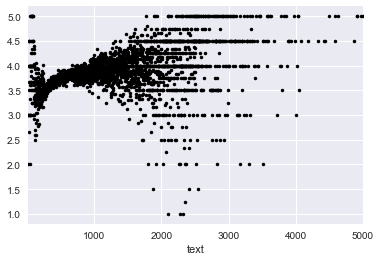

In [107]:
# %load solutions/groupby_00.py
df.groupby(df.text.str.len()).review_overall.mean().plot(style='k.');

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the relationship between review length (number of **words** and average `reveiw_overall`.

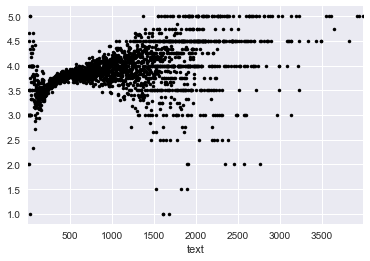

In [106]:
# %load solutions/groupby_00b.py
(df.groupby(df.text.str.count('\w'))
   .review_overall
   .mean().plot(style='k.'));


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the relationship between the number of reviews for a beer and the average `review_overall`.

In [ ]:
# %load solutions/groupby_01.py
(df.groupby('beer_id')
   .review_overall
   .agg(['mean', 'count'])
   .plot.scatter(x='count', y='mean', color='k',
                 marker='.', alpha=.25));


# Transform

This is what to use when

- You have a groupwise calculation
- The output should be the same shape as the input

For example, suppose we wanted to normalize each reviewer's scores by their average score. 

In [98]:
# Define demean(v: array) -> array
def demean(v):
    return v - v.mean()

Just calling `demean` on the entire Series will noramilze by the *global* average.

In [99]:
demean(df.review_overall)

64529    0.24891
86219    0.24891
64057    0.74891
17043    0.24891
29308   -2.75109
          ...   
51254    1.24891
88806    0.74891
7449    -0.25109
54613   -0.25109
71816   -1.25109
Name: review_overall, dtype: float64

If you're making a recommnedation system, you might want to normalize by each person's *individual* mean. A rating of 4 from someone's whose average is 2 is in some sense more meaningful that a 4 from someone who always gives 4s.

In [100]:
normalized = df.groupby("profile_name")[review_cols].transform(demean)
normalized.head()

,review_appearance,review_aroma,review_overall,review_palate,review_taste
64529,-0.122437,0.003016,0.231604,0.389023,0.278649
86219,-0.622437,0.503016,0.231604,0.889023,0.778649
64057,0.399485,0.273196,0.515464,0.250000,-0.010309
17043,-0.600515,-0.226804,0.015464,-0.250000,-0.010309
29308,-0.600515,-0.726804,-2.984536,-2.750000,-3.010309


In [101]:
normalized.shape

(100000, 5)

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Do reviewer's `review_overall` trend over a person's time reviewing?

Hint: Need an indictor that tracks which review this is for that person.

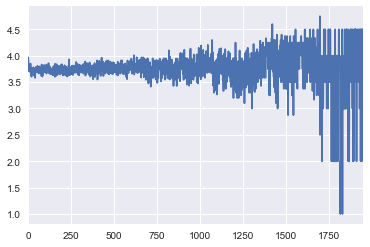

In [105]:
# %load solutions/groupby_02.py
order = df.groupby("profile_name").review_overall.cumcount()
df.groupby(order).review_overall.mean().plot();

## Cutting / Binning

Often useful as a preprocessing step to grouping.

In [104]:
df.groupby(pd.cut(df.abv, 20)).review_overall.mean()

abv
(0.275, 1.535]     2.520325
(1.535, 2.77]      3.287402
(2.77, 4.005]      3.437647
(4.005, 5.24]      3.558109
(5.24, 6.475]      3.824342
                     ...   
(18.825, 20.06]         NaN
(20.06, 21.295]    4.625000
(21.295, 22.53]         NaN
(22.53, 23.765]         NaN
(23.765, 25]       3.735294
Name: review_overall, dtype: float64